# **Import libraries**

In [1]:
import pandas as pd
import numpy as np
import scipy
import scipy.sparse as sps
import matplotlib.pyplot as plt
!pip install louvain
import louvain
import igraph as ig
import time
import pickle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 55.8 MB/s eta 0:00:00


<ipython-input-1-a3a286e981b8>:7: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be maintained. Please upgrade to the `leidenalg` package.
  import louvain


In [2]:
!pip install bertopic
from bertopic import BERTopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 15.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 16.8 MB/s eta 0:00:00
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 6.7 MB/s eta 0:00:00
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039286 sha256=b7c2e8df9140709f2714f391b72dfa231f3f719973f808933d6c28fb9baa58ef
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
  Created wheel for umap-

In [3]:
!pip install import-ipynb

# Importa il modulo Python contenente la funzione
import import_ipynb
import os
from google.colab import files


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.9 MB/s eta 0:00:00


# **Load functions for probability matrices**

In [4]:
from google.colab import drive
drive.mount('/content/drive')


%run "drive/MyDrive/lab2_NS/communities_mod.ipynb"

Mounted at /content/drive
bertopic 1.11
softlouvain v1.10


# **Load Reddit data**

In [5]:
in_dir = "drive/MyDrive/lab2_NS/"
in_file = "all_posts_results"

# load word occurrences
Mwd, words, documents = pickle.load(open(in_dir+in_file+"_occurrences.p","rb"))
Mwd = sps.csr_matrix(Mwd)

In [6]:
documents.shape

(2858,)

# **Build probability matrices from words occurrences**

In [7]:
# remove elements that are too central, e.g., #covid19
# remove documents and words with fewer than 2 links
Mwd, words, documents = clean_Mwd_matrix(Mwd,words,documents)

10
removing:   


In [8]:
# build probability matrices
# set tform=True for TF-IDF matrices
Pwd, Pww, Pdd, Paa = probability_matrices(Mwd, tform=False)

In [9]:
print(Pdd.shape)

(2730, 2730)


In [10]:
#Adjancency matrix

A = np.zeros((Pdd.shape[0], Pdd.shape[1]))

for i in range(0, Pdd.shape[0]):
  for j in range(0, Pdd.shape[1]):
    if Pdd[i,j] > 0:
      A[i,j] = 1
    else:
      A[i,j] = 0



In [11]:
import pickle

pickle.dump(A, open("A.p","wb"))

In [12]:
print(A)
print(A.shape)

[[1. 1. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
(2730, 2730)


In [13]:
#BigCLAM implementation

from numpy import log as ln

exp = 0
P = 0

#loglikelihood

def compute_log_likelihood(A, F):
  global exp
  global P

  C, D = F.shape

  M = np.dot(F.T, F)
  exp = np.exp(-M)
  P = 1 - exp

  M1 = A * ln(P)
  G = M1

  sum1 = np.sum(M1)

  M2 = (1-A) * M
  sum2 = np.sum(M2)

  log_lik = sum1 - sum2

  return log_lik

#gradient

def compute_gradient(A,F):

  frac = exp / P
  grad = np.zeros((F.shape[0],F.shape[1]))

  for i in range(0, A.shape[0]):
    var = 0
    for j in range(0, A.shape[1]):
      if A[i,j] == 1:
        var += frac[i,j] * F[:,j]
      else:
        var -= F[:,j]

    grad[:,i] = var

  return grad

#gradient descent

def bigclam_gradient_descent(A, F, learning_rate, iterations):

  for n in range(iterations):
    log_likelihood = compute_log_likelihood(A, F)
    gradient = compute_gradient(A,F)
    F = np.clip(F, 0, 1)
    F -= learning_rate * gradient
    F = np.maximum(0.001, F)

  return F


In [14]:
#finding value of F after 100 iterations

lr = 1e-4
iterations = 100
C = 15
D = A.shape[1]
F = np.random.rand(C,D)
bigclam_gradient_descent(A, F, lr, iterations)

array([[1.35613049, 1.29190876, 1.32525775, ..., 1.3537136 , 1.33364507,
        1.28591174],
       [1.35613049, 1.29190876, 1.32525775, ..., 1.3537136 , 1.33364507,
        1.28591174],
       [1.35613049, 1.29190876, 1.32525775, ..., 1.3537136 , 1.33364507,
        1.28591174],
       ...,
       [1.35613049, 1.29190876, 1.32525775, ..., 1.3537136 , 1.33364507,
        1.28591174],
       [1.35613049, 1.29190876, 1.32525775, ..., 1.3537136 , 1.33364507,
        1.28591174],
       [1.35613049, 1.29190876, 1.32525775, ..., 1.3537136 , 1.33364507,
        1.28591174]])

In [15]:
pickle.dump(F, open("F.p","wb"))

In [16]:
#creating occurrency matrices for non-overlapping and overlapping cases

prob_column = []
occur_mtx_overlapped = np.zeros((F.shape[0], F.shape[1]))
occur_mtx = np.zeros((F.shape[0], F.shape[1]))
communities = dict()
comm_overlapping = dict()

for j in range(0, F.shape[1]):
  for i in range(0, F.shape[0]):
    prob_column.append(F[i,j])

  max_prob = np.max(prob_column)
  for m in range(0, F.shape[0]):
    if F[m,j] == max_prob:
      occur_mtx[m,j] = 1

    else:
      occur_mtx[m,j] = 0

#for overlapping case: use only probabilities higher than 95% the maximum probability (arbitrary value)

  for i in range(0, len(prob_column)):
    if prob_column[i] > (0.95*max_prob):
      communities[f"p{j}"] = i
      occur_mtx_overlapped[i,j] = 1
    else:
      occur_mtx_overlapped[i,j] = 0

  prob_column.clear()

F_new  = F * occur_mtx_overlapped
ones = np.ones((F.shape[0], F.shape[1]))
d = np.dot(F_new.T, ones)
e = 1/d
F_norm = F_new * np.diag(e)

sum = F_norm.sum(axis=0) > 0.99 * np.ones(F.shape[1])


In [17]:
#creating json files for words for each of the 15 communities in BigCLAM using all the words for document in w4d.json
#in case of overlapping and non-overlapping

import json

w4c_ov = dict()
list_w4d_ov = []

for i in range(0, F_norm.shape[0]):
  for j in range(0, F_norm.shape[1]):
    if F_norm[i,j] != 0:

      w4d_json = 'drive/MyDrive/Colab Notebooks/w4d.json'

      with open(w4d_json, 'r') as file_json:
        w4d = json.load(file_json)
      list_w4d_ov.append(w4d[f"p{j}"])

  for index in range(0, len(list_w4d_ov)):
    w4c_ov[f"c{i}"] = list_w4d_ov[index]

  list_w4d_ov.clear()

print(w4c_ov)


w4c_ov_path = "drive/MyDrive/Colab Notebooks/w4c_overlapping.json"

with open(w4c_ov_path,'w') as f:
        json.dump(w4c_ov,f, indent=4)



{'c0': ['call VERB', 'club NOUN', 'collapse NOUN', 'communism NOUN', 'declare VERB', 'document NOUN', 'entitle VERB', 'first ADJ', 'globalist NOUN', 'guise NOUN', 'humanity NOUN', 'new ADJ', 'planet NOUN', 'pretext NOUN', 'release VERB', 'revolution NOUN', 'rome PROPN', 'save VERB', 'shortly ADV', 'tank NOUN', 'think NOUN', 'wage VERB', 'war NOUN'], 'c1': ['al PROPN', 'arctic PROPN', 'check VERB', 'chief ADJ', 'comment NOUN', 'cover NOUN', 'expand VERB', 'forecast VERB', 'fraud NOUN', 'free ADJ', 'gore PROPN', 'have VERB', 'ice NOUN', 'ice PROPN', 'man NOUN', 'peddler NOUN', 'post VERB', 'publish VERB', 'see VERB'], 'c2': ['corrupt ADJ', 'fear VERB', 'german ADJ', 'head VERB', 'monger VERB', 'rich ADJ', 'scheme NOUN', 'scientist NOUN', 'super ADJ'], 'c3': ['expert NOUN', 'mysteriously ADV', 'spike VERB', 'year NOUN'], 'c4': ['ago ADV', 'day NOUN', 'degc ADJ', 'fall VERB', 'heavy ADJ', 'people NOUN', 'snowfall NOUN', 'snowflake NOUN', 'switzerland NOUN', 'think VERB', 'zermatt PROPN'], 

In [18]:
import json

w4c = dict()
list_w4d = []

for i in range(0, occur_mtx.shape[0]):
  for j in range(0, occur_mtx.shape[1]):
    if occur_mtx[i,j] == 1:
      w4d_json = 'drive/MyDrive/Colab Notebooks/w4d.json'

      with open(w4d_json, 'r') as file_json:
        w4d = json.load(file_json)
      list_w4d.append(w4d[f"p{j}"])

  for index in range(0, len(list_w4d)):
        w4c[f"c{i}"] = list_w4d[index]

  list_w4d.clear()


w4c_path = "drive/MyDrive/Colab Notebooks/w4c.json"

with open(w4c_path,'w') as f:
        json.dump(w4c,f, indent=4)

In [19]:
F_argmax = np.argmax(F,0)
print(F_argmax)

label_community = ['Comunità_0', 'Comunità_1', 'Comunità_2', 'Comunità_3', 'Comunità_4', 'Comunità_5', 'Comunità_6', 'Comunità_7', 'Comunità_8', 'Comunità_9', 'Comunità_10', 'Comunità_11', 'Comunità_12', 'Comunità_13', 'Comunità_14']

predict_community = []

for idx in F_argmax:
    try:
        predict_community.append(label_community[idx])
    except IndexError:
        predict_community.append('Non valid community')

print(predict_community)


[ 5  3  4 ...  6 14 12]
['Comunità_5', 'Comunità_3', 'Comunità_4', 'Comunità_14', 'Comunità_7', 'Comunità_13', 'Comunità_1', 'Comunità_6', 'Comunità_13', 'Comunità_0', 'Comunità_8', 'Comunità_14', 'Comunità_6', 'Comunità_12', 'Comunità_9', 'Comunità_0', 'Comunità_10', 'Comunità_5', 'Comunità_4', 'Comunità_3', 'Comunità_8', 'Comunità_4', 'Comunità_13', 'Comunità_4', 'Comunità_2', 'Comunità_1', 'Comunità_6', 'Comunità_10', 'Comunità_3', 'Comunità_10', 'Comunità_4', 'Comunità_5', 'Comunità_9', 'Comunità_13', 'Comunità_6', 'Comunità_6', 'Comunità_9', 'Comunità_6', 'Comunità_9', 'Comunità_0', 'Comunità_14', 'Comunità_12', 'Comunità_2', 'Comunità_7', 'Comunità_0', 'Comunità_3', 'Comunità_13', 'Comunità_1', 'Comunità_11', 'Comunità_12', 'Comunità_10', 'Comunità_0', 'Comunità_6', 'Comunità_7', 'Comunità_5', 'Comunità_0', 'Comunità_8', 'Comunità_11', 'Comunità_9', 'Comunità_11', 'Comunità_0', 'Comunità_7', 'Comunità_1', 'Comunità_2', 'Comunità_8', 'Comunità_10', 'Comunità_0', 'Comunità_7', 'Com

In [20]:
len(predict_community)

2730

In [21]:
import pickle

F = pickle.load(open("F.p", "rb"))


In [22]:
print(F.shape)

(15, 2730)


In [23]:
from scipy .sparse import csr_matrix

In [24]:
#METRICS

#modularity Q
def modularity_function(A):
    y = A.trace()-(A.sum(axis=0)*A.sum(axis=1)).item()
    return y


#Ncut
def ncut_function(A):
    y = ((A.sum(axis=0)-A.diagonal())/A.sum(axis=0)).mean()
    return y

#Nmi
def nmi_function(A):
    aw = A.sum(axis=1).flatten()
    ac = A.sum(axis=0).flatten()
    Hc = np.multiply(ac,-logg(ac)).sum()
    A2 = ((A/ac).T/aw).T
    A2.data = logg(A2.data)
    y = (A.multiply(A2)).sum()/Hc
    return y

#Infomap
def my_pagerank(M,q,c=.85,it=60):
    r = q.copy()
    for k in range(it):
      r = c*M.dot(r) + (1-c)*q
    return r

occur_mtx = csr_matrix(occur_mtx)
Mm = occur_mtx * Pdd
M = Mm * occur_mtx.T

F_norm = csr_matrix(F_norm)
Mm_ov = F_norm * Pdd
M_ov = Mm_ov * F_norm.T

Q = modularity_function(M)
print("Q", Q)

Q_ov = modularity_function(M_ov)
print("Q overlapping", Q_ov)

Ncut = ncut_function(M)
print("Ncut", Ncut)

Ncut_ov = ncut_function(M_ov)
print("Ncut overlapping", Ncut_ov)


Nmi = nmi_function(M)
print("Nmi", Nmi)

Nmi_ov = nmi_function(M_ov)
print("Nmi overlapping", Nmi_ov)


def infomap_rank(Pdd):
    # transition matrix
    pd = Pdd.sum(axis=0).flatten()
    M = sps.csr_matrix(Pdd/pd)
    # pagerank vector - faster than r = my_pagerank(M,q)
    G = ig.Graph.Adjacency((M > 0).toarray().tolist())
    G.es['weight'] = np.array(M[M.nonzero()])[0]
    r = G.pagerank(weights='weight')
    r = (sps.csr_matrix(np.array(r))).T

    return r

def infomap(C,Pdd,r):
    pd = Pdd.sum(axis=0).flatten()
    M = Pdd/pd # transition matrix
    # extract vectors
    z = C.T*sps.diags(r.toarray().flatten())
    q = sps.csr_matrix((1,z.shape[0]))
    c = .85
    for i in range(z.shape[0]):
      tmp = (C[:,i].transpose()*M)*z[i].transpose()
      q[0,i] = (1-(1-c)*C[:,i].sum()/M.shape[0])*z[i].sum()-c*tmp[0,0]
    # extract statistics
    y = infomap_function(q)
    for i in range(z.shape[0]):
      y += infomap_function(sps.hstack([z[i],sps.csr_matrix([[q[0,i]]])]))
    # normalize
    y = (y/infomap_function(pd))-1

    return y

r = infomap_rank(Pdd)
Infomap = infomap(occur_mtx.T,Pdd,r)
print("Infomap", Infomap)
Infomap_ov = infomap(F_norm.T,Pdd,r)
print("Infomap overlapping", Infomap_ov)


Q 0.11795101766521764
Q overlapping 0.08048892124778861
Ncut 0.8154684493533982
Ncut overlapping 0.852888530692755
Nmi 0.02901811561611723
Nmi overlapping 0.014787796849789968
<class 'int'>
(15, 2730)


/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Infomap 0.10246663726692407
Infomap overlapping 0.17142482030583328


# **Assign documents to topics using Louvain**
i.e., run Louvain community detection on Pdd

In [25]:
# start a time counter
tic = time.time()

# build a graph based on Pdd as adjacency matrix
A = sps.csr_matrix(Pdd)
G = ig.Graph.Adjacency((A > 0).toarray().tolist())
G.es['weight'] = np.array(A[A.nonzero()])[0]

# run Louvain on the graph to get a partition
part = louvain.find_partition(G, louvain.ModularityVertexPartition,
                                 weights='weight')

# function to map the partition into a community assignment matrix C
# where rows represent documents, and columns represent topics
def partition_to_C(part):
  C = sps.csr_matrix((Pdd.shape[0],len(part)))
  for i in range(len(part)):
    C[np.array(part[i]),i] = 1
  return C

# map the partition into a community assignment matrix C
C_l = partition_to_C(part)

# capture execution time
et_louv = time.time()-tic

# refine with soft Louvain
C_sl, _, _ = my_soft_louvain(Pdd, C_l)

# capture execution time
et_slouv = time.time()-tic

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


[2730, 2730]
254.55844122715797
90.50966799187799
50.9116882454314
22.62741699796953
15.55634918610405
14.142135623730955
5.656854249492381
0.0
[2730, 28]
4.242640687119286
0.0
[2730, 26]
0.0


# **Assign documents to topics using BERTopic**
i.e., run BERTopic detection on superficially cleaned text

In [26]:
# load text
df2 = pd.read_excel(in_dir+in_file+"_cleaned2.xlsx")
df2["id"] = np.array([str(i) for i in df2["id"]])

# remove those documents that do not appear in Pcc
documents = np.array([str(i) for i in documents])
df2 = df2.loc[df2['id'].isin(documents)]
df2.index = np.array(range(len(df2)))

# workaround to reinsert hashtags (if any) in the cleaned text
df2["text_deep_clean2"] = [str(df2["text_deep_clean"][i]) + " #" +
                           df2["hashtags"][i][2:-2].replace("', '"," #")
                           for i in range(len(df2))]

In [27]:
# start a time counter
tic = time.time()

# prepare a BERTopic instance
bert_model = BERTopic()

# run BERTopic
docs = list(df2["title"])
topics, probabilities = bert_model.fit_transform(docs)

# reduce the number of topics only in case it is needed!
# topics = bert_model.reduce_outliers(docs, topics)

# function to map the topis into a community assignment matrix C
# where rows represent documents, and columns represent topics
def topics_to_C(topics):
  # extract community assignments
  C = sps.csr_matrix((len(topics),max(topics)+2))
  for i in range(C.shape[1]):
    C[np.array(topics)==(i-1),i] = 1
  # remove zero assignments
  C = C[:,np.unique(scipy.sparse.find(C)[1])]
  return C

# map the topics into a community assignment matrix C
C_b = topics_to_C(topics)

# capture execution time
et_bert = time.time()-tic

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


# **Evaluate NMI, modulartity, Ncut, and Infomap metrics**

In [28]:
# prepare a template dataframe for collecting the results
df = pd.DataFrame(data={'data':[],'algo':[],'time':[],'c#':[],
                        'NMI':[],'Q':[],'Ncut':[],'InfoMap':[]})

# identify the infomap ranking vector
r = infomap_rank(Pdd)

In [29]:
# hard Louvain: evaluate the statistics of interest
stats = clustering_statistics(C_l,Pwd,Pdd,r)
# store them into the dataframe
df.loc[len(df)] = [in_file,"hard Louvain Pdd",et_louv,C_l.shape[1]] + stats

# soft Louvain: evaluate the statistics of interest
stats = clustering_statistics(C_sl,Pwd,Pdd,r)
# store them into the dataframe
df.loc[len(df)] = [in_file,"soft Louvain Pdd",et_slouv,C_sl.shape[1]] + stats

# BERTopic: evaluate the statistics of interest
stats = clustering_statistics(C_b,Pwd,Pdd,r)
# store them into the dataframe
df.loc[len(df)] = [in_file,"BERTopic",et_bert,C_b.shape[1]] + stats

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [30]:
# display the result
display(df)

,data,algo,time,c#,NMI,Q,Ncut,InfoMap
0,all_posts_results,hard Louvain Pdd,6.628382,28,0.529467,0.340197,0.609215,0.005629
1,all_posts_results,soft Louvain Pdd,30.722283,26,0.528351,0.341344,0.606032,0.005987
2,all_posts_results,BERTopic,72.064601,61,0.509529,0.210574,0.743915,0.038725


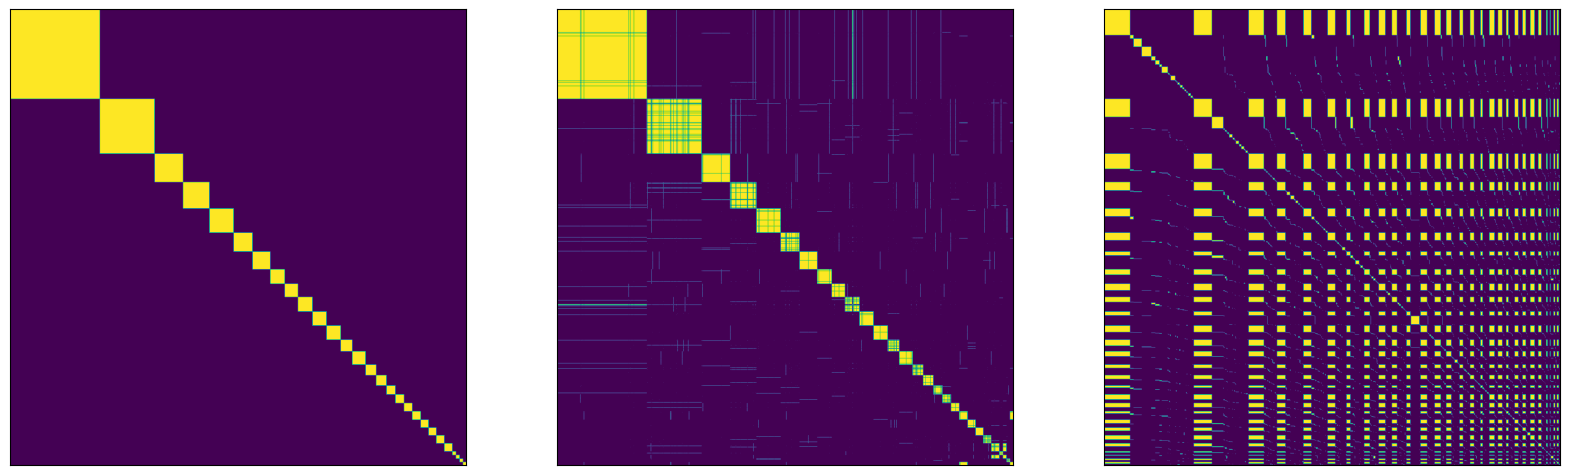

In [31]:
# show community patterns and their relations
plot_community_patterns([C_l,C_sl,C_b],nrows=1,ncols=3,refs=[0,2])

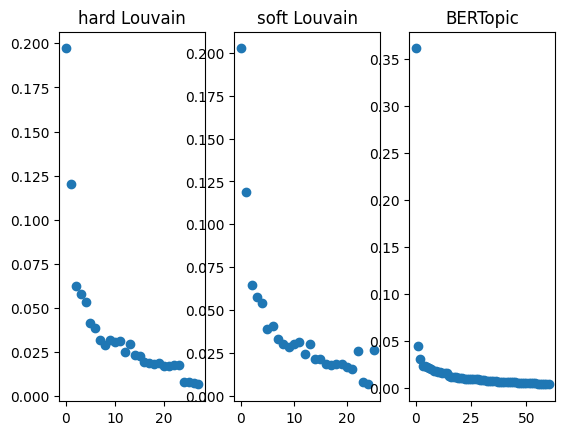

In [32]:
# show number of documents per community
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(np.array(C_l.sum(axis=0))[0]/C_l.sum(),'o')
ax1.set_title('hard Louvain')
ax2.plot(np.array(C_sl.sum(axis=0))[0]/C_sl.sum(),'o')
ax2.set_title('soft Louvain')
ax3.plot(np.array(C_b.sum(axis=0))[0]/C_b.sum(),'o')
ax3.set_title('BERTopic');

# **Visualize the result using BERTopic tools**

In [33]:
# Louvain first

# use the clean text in order to get a more meaningful description
docs = list(df2["text_deep_clean2"])
bert_model1 = bertopic_overwrite(bert_model,docs,C_l)

# visualize topic description
bert_model1.visualize_barchart(topics = range(C_l.shape[1]),
                               n_words = 8,
                               title = "Louvain results")

In [34]:
# BERTopic second

# use the clean text in order to get a more meaningful description
docs = list(df2["text_deep_clean"])
bert_model2 = bertopic_overwrite(bert_model,docs,C_b)

# visualize topic description
bert_model2.visualize_barchart(topics = range(C_b.shape[1]),
                               n_words = 8,
                               title = "BERTopic results")

In [35]:
# BigCLAM

# use the clean text in order to get a more meaningful description
docs = list(df2["text_deep_clean"])
bert_model2 = bertopic_overwrite(bert_model,docs,occur_mtx.T)

# visualize topic description
bert_model2.visualize_barchart(topics = range((occur_mtx.T).shape[1]),
                               n_words = 8,
                               title = "bigCLAM results")